In [16]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
import gym
env = gym.make("CartPole-v1")
obs = env.reset()
obs
####각각 카트 수평위치, 카트 속도, 막대 각도, 막대 각속도

array([-0.02681879, -0.02283024, -0.04061721,  0.04250251], dtype=float32)

In [3]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


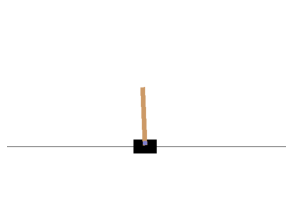

In [4]:
plot_environment(env)
plt.show()

In [5]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [6]:
env.action_space

Discrete(2)

In [7]:
action=1
obs, reward, done, info = env.step(action)
obs

array([-0.02727539,  0.1728499 , -0.03976715, -0.2627138 ], dtype=float32)

In [8]:
reward

1.0

In [9]:
done

False

In [10]:
info

{}

In [27]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1
totals=[]
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [28]:
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

42.19 9.220732075057814 25.0 66.0


In [29]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [30]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [31]:
plot_animation(frames)

In [33]:
n_inputs = 4
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

# 정책 그래디언트 

In [48]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 2]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
###### tf,reduce_mean은 텐서의 특정 축 값을 전부 더해서 len(원소 수)로 나눠줌 없을 시 모든 원소 합함
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [49]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [50]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [51]:
discount_rewards([10, 0, -50], 0.8)

array([-22, -40, -50])

In [53]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [54]:
n_iteration=150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [55]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [66]:
for iteration in range(n_iteration):
    all_rewards, all_grads = play_multiple_episodes(
    env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads=[]
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [68]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [69]:
frames = render_policy_net(model)
plot_animation(frames)

In [84]:
np.array(all_rewards[9]).sum()

200.0